In [1]:
import numpy as np
import os
import shutil
import PIL.Image as Image
import PIL.ImageDraw as  ImageDraw
from  queue import Queue
import tqdm
import cv2
import matplotlib.pyplot as plt

In [2]:
fold_dir = 'FDDB-folds/'
folds = os.listdir(fold_dir)
folds.sort()
folds_anno = folds[::2]
folds_anno

['FDDB-fold-01-ellipseList.txt',
 'FDDB-fold-02-ellipseList.txt',
 'FDDB-fold-03-ellipseList.txt',
 'FDDB-fold-04-ellipseList.txt',
 'FDDB-fold-05-ellipseList.txt',
 'FDDB-fold-06-ellipseList.txt',
 'FDDB-fold-07-ellipseList.txt',
 'FDDB-fold-08-ellipseList.txt',
 'FDDB-fold-09-ellipseList.txt',
 'FDDB-fold-10-ellipseList.txt']

## Folds Loader

In [3]:
class fold_loader():
    def __init__(self, file):
        self.fhand = open(file)
        self.curr_img = ''
        self.num_head = 0
        self.curr_head = 0
        self.heads_in_img = Queue()
    def __iter__(self):
        return self
    def __next__(self):
        if not self.heads_in_img.empty():
            self.curr_head+=1
            return self.curr_img, self.heads_in_img.get(), self.curr_head
        else:
            self.curr_head=0
            line = self.fhand.readline()
            if line:
                self.curr_img = line.rstrip()
                self.num_head = int(self.fhand.readline().rstrip())
                if self.num_head == 0:
                    return self.__next__()
                for i in range(self.num_head):
                    self.heads_in_img.put([eval(t) for t in self.fhand.readline().rstrip().split()])     
                return self.curr_img, self.heads_in_img.get(), self.curr_head
            else:
                raise StopIteration

## Cropping!

In [6]:
faces_dir = 'faces/'
factor = 1+2/3

In [7]:
def crop(img, box): # box x1,y1,x2,y2
    box = [int(i) for i in box]
    return img[box[1]:box[3], box[0]:box[2]]

In [6]:
for f in tqdm.tqdm(folds_anno):
    loader = fold_loader(os.path.join(fold_dir,f))
    for img,face,idx in loader:
        dirs, _ = os.path.split(img)
        out_dirs = os.path.join(faces_dir,dirs)
        os.makedirs(out_dirs, exist_ok=True)
        raw = cv2.imread(img+'.jpg')
        x,y = face[3:5]
        rh,rw = face[:2]
        bx = int(rw)*4; by = int(rh)*4;
        x+=bx; y+=by;
        raw_expand = cv2.copyMakeBorder(raw,by,by,bx,bx,cv2.BORDER_REPLICATE) # Up Down Left Right
        box = (x-factor*rw,y-factor*rh,x+factor*rw,y+factor*rh)
        cropped = crop(raw_expand, box)
        cv2.imwrite(os.path.join(faces_dir,img)+f'_{idx}.jpg',cropped)      
        


100%|██████████| 10/10 [00:25<00:00,  1.89s/it]


## Dataloader

In [8]:
train_list = []
val_list = []

In [9]:
# positive sampling
for f in tqdm.tqdm(folds_anno[:8]):
    loader = fold_loader(os.path.join(fold_dir,f))
    for img,face,idx in loader:
        train_list.append((os.path.join(faces_dir,img)+f'_{idx}.jpg',8))
for f in tqdm.tqdm(folds_anno[-2:]):
    loader = fold_loader(os.path.join(fold_dir,f))
    for img,face,idx in loader:
        val_list.append((os.path.join(faces_dir,img)+f'_{idx}.jpg',8))


100%|██████████| 2/2 [00:00<00:00, 31.25it/s]


In [20]:
train_list[:10]

[('faces/2002/08/11/big/img_591_0.jpg', 8),
 ('faces/2002/08/26/big/img_265_0.jpg', 8),
 ('faces/2002/08/26/big/img_265_1.jpg', 8),
 ('faces/2002/08/26/big/img_265_2.jpg', 8),
 ('faces/2002/07/19/big/img_423_0.jpg', 8),
 ('faces/2002/08/24/big/img_490_0.jpg', 8),
 ('faces/2002/08/31/big/img_17676_0.jpg', 8),
 ('faces/2002/08/31/big/img_17676_1.jpg', 8),
 ('faces/2002/07/31/big/img_228_0.jpg', 8),
 ('faces/2002/07/31/big/img_228_1.jpg', 8)]

In [10]:
# negative sampling
for f in tqdm.tqdm(folds_anno[:4]):
    loader = fold_loader(os.path.join(fold_dir,f))
    for img,face,idx in loader:
        for i in range(8):
            train_list.append((os.path.join(faces_dir,img)+f'_{idx}.jpg',i))
for f in tqdm.tqdm(folds_anno[-1:]):
    loader = fold_loader(os.path.join(fold_dir,f))
    for img,face,idx in loader:
        for i in range(8):
            val_list.append((os.path.join(faces_dir,img)+f'_{idx}.jpg',i))

100%|██████████| 1/1 [00:00<00:00, 22.92it/s]


In [22]:
train_list[-10:]

[('faces/2002/08/13/big/img_380_0.jpg', 6),
 ('faces/2002/08/13/big/img_380_0.jpg', 7),
 ('faces/2002/08/13/big/img_380_1.jpg', 0),
 ('faces/2002/08/13/big/img_380_1.jpg', 1),
 ('faces/2002/08/13/big/img_380_1.jpg', 2),
 ('faces/2002/08/13/big/img_380_1.jpg', 3),
 ('faces/2002/08/13/big/img_380_1.jpg', 4),
 ('faces/2002/08/13/big/img_380_1.jpg', 5),
 ('faces/2002/08/13/big/img_380_1.jpg', 6),
 ('faces/2002/08/13/big/img_380_1.jpg', 7)]

In [11]:
np.save('train_list.npy', train_list)
np.save('val_list.npy', val_list)

In [12]:
class FDDB():
    def __init__(self, datalist, transform = None, crop=True, zero_one = False):
        self.datalist = np.load(datalist).tolist()
        self.directions = np.array([
           [ 1,  0,  1,  0],
           [ 0,  1,  0,  1],
           [-1,  0, -1,  0],
           [ 0, -1,  0, -1],
           [ 1,  1,  1,  1],
           [-1, -1, -1, -1],
           [ 1, -1,  1, -1],
           [-1,  1, -1,  1],
           [ 0,  0,  0,  0]
        ])
        self.transform = transform
        self.crop = crop
        self.zero_one = zero_one
    
    def __len__(self):
        return len(self.datalist)
    
    def __getitem__(self, idx):
        img, pos = self.datalist[idx]
        pos = int(pos)
        img = Image.open(img)
        if self.crop:
            w,h = img.size
            wi,hi = w/5, h/5
            offset = np.array([wi,hi,wi,hi])
            bndbox = np.array([wi,hi,4*wi,4*hi])
            bndbox = bndbox + self.directions[pos] * offset
            img = img.crop(bndbox)
        if self.transform is not None:
            img = self.transform(img)
        label = 1 if pos == 8 else (0 if self.zero_one else -1)
        return img, label
    def draw_bndbox(self, idx, mypos): # input PIL image
        img, pos = self.datalist[idx]
        pos = int(pos) if mypos is None else mypos
        img = Image.open(img)
        w,h = img.size
        wi,hi = w/5, h/5
        offset = np.array([wi,hi,wi,hi])
        bndbox = np.array([wi,hi,4*wi,4*hi])
        bndbox = bndbox + self.directions[pos] * offset * 0.99
        # Draw!
        draw = ImageDraw.Draw(img)
        draw.line(bndbox[[0,1,2,1,2,3,0,3,0,1]].tolist(), fill='red')
        return img
        

In [65]:
db = FDDB('train_list.npy',crop=True, zero_one=True)
db[6000][1]

0

In [57]:
db.datalist[456]

['faces/2002/08/30/big/img_18395_2.jpg', '8']

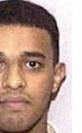

In [58]:
db[10000][0]

In [ ]:
db.draw_bndbox(3)

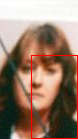

In [81]:
db.draw_bndbox(9100)

In [27]:
a = np.array([2,3,4,5])
a[[0,1]]

array([2, 3])